Hyperparameters definition and loading of CIFAR100 from pytorch torchvision

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

#hyperparameters
batch_size = 100

pad_totensor_transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()]) # does the padding, images 32x32 become 36x36 (symmetric increase) so that are divisible by three and patches are 12x12

train_dataset = torchvision.datasets.CIFAR100(root='./cifar100_data', train=True, transform=pad_totensor_transform, download=True)

test_dataset = torchvision.datasets.CIFAR100(root='./cifar100_data', train=False, transform=pad_totensor_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified


In [5]:
#test dataloader

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([100, 3, 36, 36]) torch.Size([100])


torch.Size([3, 36, 36])


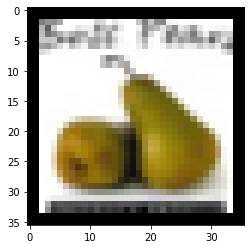

In [11]:
import matplotlib.pyplot as plt

one = samples[0]
print(one.shape)
plt.imshow(one.permute(1, 2, 0))
plt.show()